In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as sps

In [2]:
P0 = 35
T = 4*60*60
lamb = 1/300
N=100
alpha = -0.875

#Pour MC
saut_1 = lambda x: np.ones(shape=x) #correspond à m=1
saut_2 = lambda x: np.random.choice([1, 2, 3], size=x, replace=True, p=np.array([1/2, 1/3, 1/6])) #correspond à m=3

value_2 = np.array([1, 1, 1, 2, 2, 3])
saut_2 = lambda x : value_2[np.random.randint(low=6, size=x)]

#Pour sélection-mutation
saut_1_vect = lambda x,y : np.ones(shape=(x,y))
saut_2_vect = lambda x,y: value_2[np.random.randint(low=6, size=(x, y))]

In [3]:
def part_interaction(N,saut,P0,M,alpha,mu):
    #mu: paramètre des poids G_p
    # Tirages de M x N v.a. suivant la loi "saut" et de MxN v.a. delta_n représentant le changement de signe du saut par rapport au signe du saut précédent
    # seront utilisees pour construire les chaînes de Markov
    xi= saut(M, N)   #N: horizon temporel (nombre de sauts)
    delta = -1+2*np.random.binomial(1,(1+alpha)/2,size=(M,N-1))

    ###############################################################################
    ## En ponderant les trajectoires hautes : Estimation via G(X)=e^{alpha X_p}
    ###############################################################################

    # P stocke TOUTES LES VALEURS pour chacune des M chaines, dans l'optique du calcul de G_p 
    # J_hat stocke la dernière valeur du signe de saut (saut vers le bas ou vers le haut) pour chacune des M chaînes
    P = np.zeros((M,N))

    J_hat = -1+2*np.random.binomial(1,0.5,size=M) #le premier saut est vers le bas ou vers le haut avec la même probabilité

    # On initialise avec la valeur du prix après le premier saut
    P[:,0] = P0+J_hat*xi[:,0]
        
    facteurDroite = 1 #produit des moyennes des pondérations à chaque itération

    for k in range(N-1):
                
        weights = np.exp(-mu*P[:,k])
        
        facteurDroite *= np.mean(weights)
        
        
        weights = weights/np.sum(weights)

        I = np.random.choice(np.arange(M),size=M,replace=True,p=weights)
        
        #sélection
        P = P[I,:]
        J_hat=J_hat[I]

        #mutation

        J_hat=J_hat*delta[:,k]
        P[:,k+1] = P[:,k] +xi[:,k+1]*J_hat

    #px_final_moyen=np.mean(P) #pour ajuster mu
    tabFacteursGauche = np.exp(mu*np.sum(P[:,:-1],axis=1)) #tableau des 1/(\prod_{k=0}^{N-2} G_k)
    proba_negatif = np.sum(tabFacteursGauche[np.min(P,axis=1)<0])/M * facteurDroite
    return proba_negatif

In [4]:
#Monte-Carlo naïf - Méthode 1

def Q3_proba_negatif(N,saut,P0,M,alpha): 
    liste_px_inf_0 = np.zeros(M)
    for i in range(M):
        increments = saut(N)
        signes = -1+2*np.random.binomial(1,(1+alpha)/2,size=N)

        signes[0] = -1+np.random.binomial(1,0.5)*2

        signes = np.cumprod(signes)
        prix = P0 +np.cumsum(increments*signes)

        if np.min(prix)<0:
            liste_px_inf_0[i] = 1
        else:
            liste_px_inf_0[i] = 0
    return np.mean(liste_px_inf_0)


CPU times: user 1h 32min 17s, sys: 1min 53s, total: 1h 34min 11s
Wall time: 1h 34min 41s


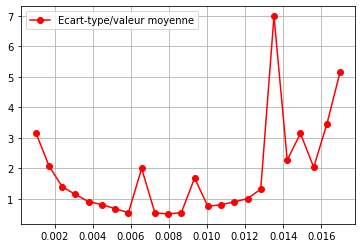

In [6]:
%%time
#Ajuster mu 

M= int(1e4)
P0= 35
N=100
n=1000
liste_mu = np.linspace(0.001,0.017,24)
estimateurs = np.zeros((len(liste_mu),n))

for i in range(len(liste_mu)):
    for j in range(n):
        estimateurs[i,j]=part_interaction(N,saut_2_vect,P0,M,alpha,liste_mu[i])

plt.plot( liste_mu,np.std(estimateurs,axis=1)/np.mean(estimateurs,axis=1),'r-o',label="Ecart-type/valeur moyenne")

plt.grid()
plt.legend(loc="best")

/home/pgi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in double_scalars
/home/pgi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars


CPU times: user 17min 34s, sys: 34.4 s, total: 18min 9s
Wall time: 18min 12s


/home/pgi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


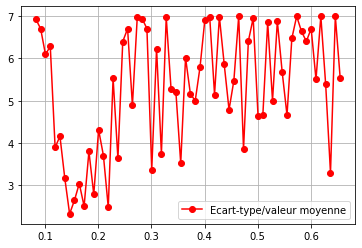

In [5]:
%%time
#Ajuster mu 

M= int(1e4)
P0= 35
N=100
n=50
liste_mu = np.linspace(0.001,0.9,100)
estimateurs = np.zeros((len(liste_mu),n))

for i in range(len(liste_mu)):
    for j in range(n):
        estimateurs[i,j]=part_interaction(N,saut_1_vect,P0,M,alpha,liste_mu[i])

plt.plot( liste_mu,np.std(estimateurs,axis=1)/np.mean(estimateurs,axis=1),'r-o',label="Ecart-type/valeur moyenne")

plt.grid()
plt.legend(loc="best")


CPU times: user 1h 28min 44s, sys: 1min 28s, total: 1h 30min 12s
Wall time: 1h 30min 42s


/home/pgi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


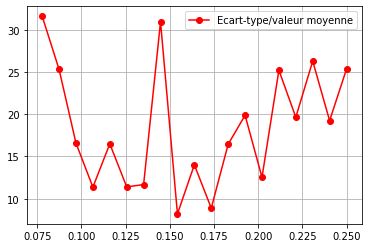

In [8]:
%%time
from tqdm.notebook import tqdm
#Ajuster mu 

M= int(1e4)
P0= 35
N=100
n=1000
liste_mu = np.linspace(0.15,0.5,100)
estimateurs = np.zeros((len(liste_mu),n))

for i in tqdm(range(len(liste_mu))):
    for j in range(n):
        estimateurs[i,j]=part_interaction(N,saut_1_vect,P0,M,alpha,liste_mu[i])

plt.plot( liste_mu,np.std(estimateurs,axis=1)/np.mean(estimateurs,axis=1),'r-o',label="Ecart-type/valeur moyenne")

plt.grid()
plt.legend(loc="best")

In [10]:
%%time
M= int(1e7)
P0= 35
N=100
mu = 0.008 #ajusté empiriquement

#proba_negatif = Q3_proba_negatif(N,saut_2,P0,M,alpha) #pour utiliser la méthode naïve
#proba_negatif = part_interaction(N,saut_2_vect,P0,M,alpha,mu) #pour utiliser la méthode mutation/selection

L= 10
probas_negatif = np.zeros(L)
for l in range(L):
    probas_negatif[l] = part_interaction(N,saut_2_vect,P0,M,alpha,mu)
R_IC= np.sqrt(np.var(probas_negatif)/L)*sps.t.ppf(0.975,df=L-1) #quantile de la loi de Student 
print("Probabilité que le prix prenne des valeurs négatives au cours des N premiers sauts : {}+/- {}".format(np.mean(probas_negatif),R_IC))

#Pour P0=10 et m=3 et M=10^5 et N=100, donne 0.2262 avec MC naif
#Donne 0.2331 avec méthode particules en interaction (mu=0.03/P0)
#pour P0=35, particules en interaction donne 5.027933935719282e-05

Probabilité que le prix prenne des valeurs négatives au cours des N premiers sauts : 4.4112466515841576e-05+/- 5.278958482090444e-07
CPU times: user 3h 21s, sys: 12min 21s, total: 3h 12min 42s
Wall time: 3h 13min 15s


In [11]:
%%time
mu = 0.15 #ajusté empiriquement

L= 10
probas_negatif = np.zeros(L)
for l in range(L):
    probas_negatif[l] = part_interaction(N,saut_1_vect,P0,M,alpha,mu)
R_IC= np.sqrt(np.var(probas_negatif)/L)*sps.t.ppf(0.975,df=L-1) #quantile de la loi de Student 
print("Probabilité que le prix prenne des valeurs négatives au cours des N premiers sauts : {}+/- {}".format(np.mean(probas_negatif),R_IC))

Probabilité que le prix prenne des valeurs négatives au cours des N premiers sauts : 1.6076674902949438e-35+/- 2.677818732690566e-35
CPU times: user 3h 2min 1s, sys: 20min 6s, total: 3h 22min 7s
Wall time: 3h 53min 16s


### Estimation de quantiles du prix final après N sauts

In [0]:
#Quantile simple 


def Quantile_naif_2(seuil,N,saut,P0,M,alpha):

    liste_P_t = np.zeros(M)
    for i in range(M):
        signes = -1+2*np.random.binomial(1,(1+alpha)/2,size=N)
        signes[0] = -1+np.random.binomial(1,0.5)*2
        signes = np.cumprod(signes)
        increments = saut(N)
        
        liste_P_t[i] = np.sum(increments*signes)+P0 
    liste_P_t = np.sort(liste_P_t)
    return liste_P_t[int(np.ceil(M*seuil))-1],liste_P_t[int(np.ceil(M*(1-seuil)))-1]

In [0]:
seuil = 1e-4
M=int(1e4)
nbIter = 10
quantiles = np.zeros((nbIter,2))

for i in range(nbIter):
    quantiles[i][0],quantiles[i][1] = Quantile_naif_2(seuil,N,saut_1,P0,M,alpha)

estimateur_quantiles = np.mean(quantiles,axis=0)
erreur = np.std(quantiles,axis=0)
print("Quantiles de niveau {} : ({} +/ {:08.7f}, {} +/ {})".format(alpha,estimateur_quantiles[0],erreur[0],estimateur_quantiles[1],erreur[1]))

Quantiles de niveau -0.875 : (24.2 +/ 0.9797958971132713, 45.4 +/ 1.2)


In [0]:
print("Quantiles de niveau {} : ({} +/ {:04.3f}, {} +/ {})".format(alpha,estimateur_quantiles[0],erreur[0],estimateur_quantiles[1],erreur[1]))

Quantiles de niveau -0.875 : (24.2 +/ 0.980, 45.4 +/ 1.2)


### Limite macroscopique

In [0]:
#Monte-Carlo 

def Q3_proba_negatif(lamb,T,saut,P0,M,alpha): 
    liste_px_inf_0 = np.zeros(M)
    for i in range(M):
        N = np.random.poisson(lamb*T)
        increments = saut(N)
        signes = -1+2*np.random.binomial(1,(1+alpha)/2,size=N)
        signes[0] = -1+np.random.binomial(1,0.5)*2
        signes = np.cumprod(signes)
        prix = P0 +np.cumsum(increments*signes)
        if np.min(prix)<0:
            liste_px_inf_0[i] = 1
        liste_px_inf_0[i] = 0
    return np.mean(liste_px_inf_0)

In [0]:
T = 8*250*24*60*60
lamb = 1/300
M = int(1e3)
P0=1000
alpha=-0.85

proba_negatif = Q3_proba_negatif(lamb,T,saut_2,P0,M,alpha)
print(proba_negatif)

0.0
